# Image tutorial for CLOS

In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
import numpy as np

from tqdm.auto import tqdm

from cleanlab import Datalab
from datasets import load_dataset, concatenate_datasets

### Neural network and helper methods for training

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
seed = 42
torch.manual_seed(seed)

# CNN net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def embeddings(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x 

# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    
    net.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return accuracy

def train(trainloader, testloader, n_epochs, patience):
        model = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        model = model.to(device)
        
        best_test_accuracy = 0.0
        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss = 0.0
            
            for _, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data['image'].to(device), data['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
            
            accuracy = get_test_accuracy(model, testloader)
            print(f'epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy}')
            
            running_loss = 0.0
            
            if  accuracy > best_test_accuracy:
                best_epoch = epoch
            
            if epoch -  best_epoch > patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
        return model

### Download and preprocess dataset

In [3]:
dataset = load_dataset("fashion_mnist")
dataset = concatenate_datasets(dataset.values())

Found cached dataset fashion_mnist (/home/sanjana/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70000
})

In [5]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format('torch')

# Apply transformations
def normalize(example):
    example['image'] = (example['image'] / 255.0).unsqueeze(0)
    return example

transformed_dataset = transformed_dataset.map(normalize)

Loading cached processed dataset at /home/sanjana/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-56aacd3c8876f154.arrow


### Create K folds for cross validation

In [6]:
nfolds = 3

kfold = KFold(n_splits=nfolds, shuffle=True, random_state=seed)
splits = kfold.split(transformed_dataset)

In [7]:
train_id_list, test_id_list  = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

### Train all the folds

In [8]:
models = []

n_epochs = 3
patience = 2
batch_size = 4

for i in range(nfolds):
    print(f"Training on fold: {i+1}")
    
    # Create train and test sets and corresponding dataloaders
    trainset = transformed_dataset.select(train_id_list[i])
    testset = transformed_dataset.select(test_id_list[i])
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    model = train(trainloader, testloader, n_epochs, patience)
    models.append(model)
print('Finished Training')

Training on fold: 1


/home/sanjana/code/cleanlab/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch: 1 loss: 0.789 test acc: 82.15908116910946
epoch: 2 loss: 0.460 test acc: 84.87614639581726
epoch: 3 loss: 0.389 test acc: 86.20467986628954
Training on fold: 2
epoch: 1 loss: 0.823 test acc: 79.97685681224017
epoch: 2 loss: 0.449 test acc: 84.90121287446964
epoch: 3 loss: 0.380 test acc: 87.01838597694253
Training on fold: 3
epoch: 1 loss: 0.772 test acc: 82.17545964942356
epoch: 2 loss: 0.457 test acc: 84.93121330304719
epoch: 3 loss: 0.385 test acc: 85.87836969099558
Finished Training


### Compute out of sample pred_probs and feature embeddings

In [9]:
pred_probs_list = []
embeddings_list = []

with torch.no_grad():
    for i in range(nfolds):
        testset = transformed_dataset.select(test_id_list[i])
        testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

        net = models[i].to(device)
        fold_pred_probs, fold_embeddings = [], []
    
        for data in tqdm(testloader):
            images, labels = data['image'].to(device), data['label'].to(device)

            outputs = net(images)
            embeddings = net.embeddings(images)

            fold_pred_probs.append(outputs.cpu())
            fold_embeddings.append(embeddings.cpu())
        
        pred_probs_list.append(torch.vstack(fold_pred_probs))
        embeddings_list.append(torch.vstack(fold_embeddings))


# Concatenate features and pred_probs
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()

  0%|          | 0/5834 [00:00<?, ?it/s]

  0%|          | 0/5834 [00:00<?, ?it/s]

  0%|          | 0/5834 [00:00<?, ?it/s]

### Post processing of the dataset

In [10]:
# Order dataset rows according to the row order in features and pred_probs
indices = np.hstack(test_id_list)
dataset = dataset.select(indices)

## Find issues using Cleanlab

In [11]:
lab = Datalab(data=dataset, label_name="label", image_key="image")
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/70000 [00:00<?, ?it/s]


Audit complete. 93979 issues found in the dataset.


### View report

Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
       grayscale       70000
 low_information       10775
         outlier        5827
           label        4713
  near_duplicate        2640
            dark          23
         non_iid           1
          blurry           0
           light           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 70000, num_classes: 10


---------------------- outlier issues ----------------------

Number of examples with this issue: 5827
Overall dataset quality in terms of this issue: 0.9858

Examples representing most severe instances of this issue:
       is_outlier_issue  outlier_score
12085              True       0.760302
29595              True       0.762832
56650              True       0.779027
44484              True       0.781130
45029              True       0.784329


----------------------- label issues -----------------------

Numb

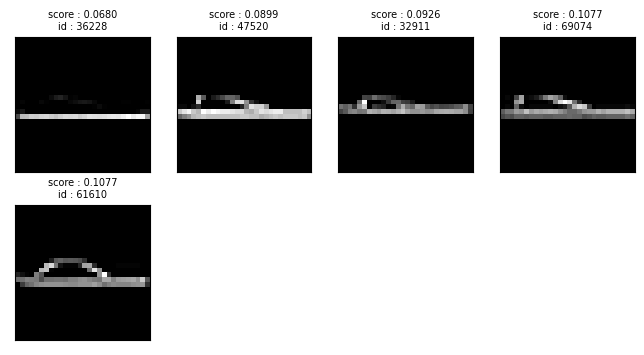

----------------------- dark images ------------------------

Number of examples with this issue: 23
Examples representing most severe instances of this issue:



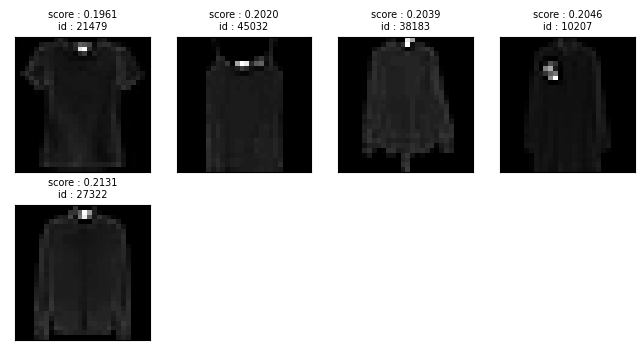

In [12]:
lab.report(include_description=False)

## Visualizing issues

### 1. Label issues

In [13]:
label_issues_df = lab.get_issues("label")
label_issues_df = label_issues_df[label_issues_df['is_label_issue'] == True].sort_values('label_score')
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
35959,True,0.000001,Coat,Bag
62916,True,0.000002,T - shirt / top,Bag
67650,True,0.000008,Bag,Trouser
19250,True,0.000009,Dress,Pullover
54312,True,0.000011,T - shirt / top,Bag


In [47]:
import matplotlib.pyplot as plt

id2label = dataset.features['label'].names

In [48]:
def plot_label_issue_examples(label_issues_df, nrows=1, ncols=1):
    count = 0
    for idx, row in label_issues_df.iterrows():
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(dataset[idx]['image'], cmap="gray")
        plt.title(f"id: {idx}\n GL: {row['given_label']}\n SL: {row['predicted_label']}", fontdict={"fontsize": 8})
        plt.axis("off")
        count += 1
        if count >= nrows * ncols:
            break

    plt.tight_layout(h_pad=2.0)

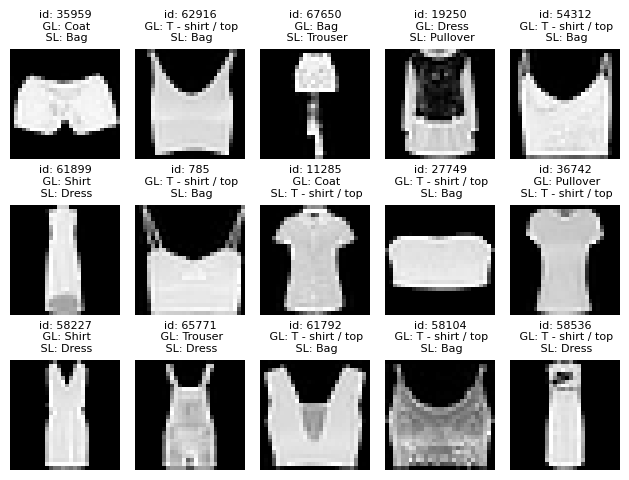

In [50]:
plot_label_issue_examples(label_issues_df, 3, 5)

In [54]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df[outlier_issues_df['is_outlier_issue'] == True].sort_values('outlier_score')
outlier_issues_df.head()

,is_outlier_issue,outlier_score
12085,True,0.760302
29595,True,0.762832
56650,True,0.779027
44484,True,0.781130
45029,True,0.784329


In [101]:
def plot_outlier_issue_examples(label_issues_df, nrows=1, ncols=1):
    label_issues = lab.get_issues('label')
    
    count = 0
    for idx, row in label_issues_df.iterrows():
        label_row = label_issues.loc[idx]
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(dataset[idx]['image'], cmap="gray")
        plt.title(f"id: {idx}\n label: {label_row['given_label']}", fontdict={"fontsize": 8})
        plt.axis("off")
        count += 1
        if count >= nrows * ncols:
            break

    plt.tight_layout(h_pad=2.0)

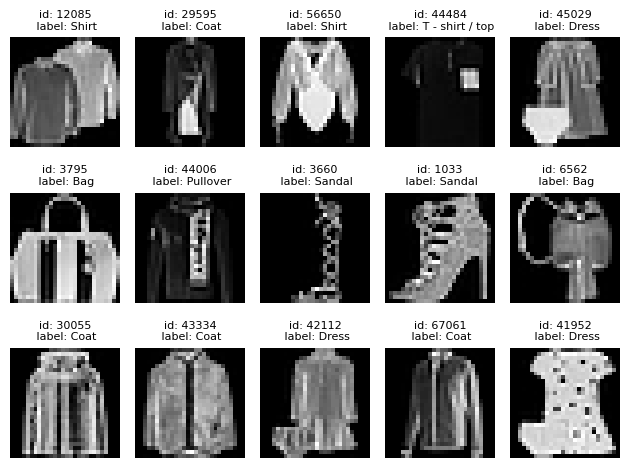

In [102]:
plot_outlier_issue_examples(outlier_issues_df, 3, 5)

In [119]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df[near_duplicate_issues_df['is_near_duplicate_issue'] == True].sort_values('near_duplicate_score')
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
33068,True,0.000001,"[23579, 30402]",0.000001
23579,True,0.000001,"[33068, 30402]",0.000001
30402,True,0.000007,"[33068, 23579]",0.000007
45022,True,0.000010,[27849],0.000010
27849,True,0.000010,[45022],0.000010


In [135]:
def plot_nd_issue_examples(nd_issues_df, nrows=1, ncols=1):
    count = 0
    for idx, row in nd_issues_df.iterrows():
        print(count)
        nd_indices = [idx]
        nd_indices.extend(row['near_duplicate_sets'])

        print(nd_indices)
        sub_count = 0
        for nd_idx in nd_indices:
            nd_idx = int(nd_idx)
            plt.subplot(1, len(nd_indices), sub_count + 1)
            plt.imshow(dataset[nd_idx]['image'], cmap="gray")
            plt.title(f"id: {nd_idx}", fontdict={"fontsize": 8})
            plt.axis("off")
            sub_count += 1
        
        count += 1
        if count >= nrows:
            break
    plt.tight_layout(h_pad=2.0)

0
[33068, 23579, 30402]
1
[23579, 33068, 30402]
2
[30402, 33068, 23579]


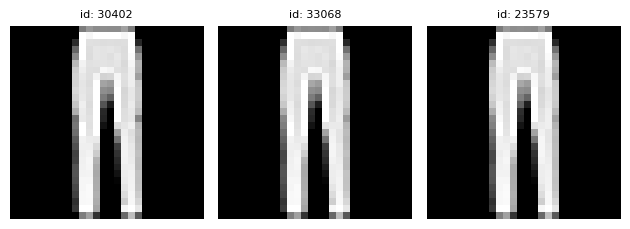

In [136]:
plot_nd_issue_examples(near_duplicate_issues_df, nrows=3)